In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d


Bad key "text.kerning_factor" on line 4 in
C:\Users\sarth\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [35]:
hr = 24 #hours?
days = 365

PVsize = 1700 #Watts
pvData = pd.read_csv('pvwatts_hourly.csv', skiprows = 17) #From PVwatts Calculator
DC_output = pvData['DC Array Output (W)'] #DC Array Output (W)
daily_output = DC_output.iloc[:-1].values #drop final totals row

# np.reshape was not giving the right
# array; need a better solution to 
# the nested for loops
x = np.zeros(shape=(24,365))
i = 0
for d in range(365):
    for h in range(24):
        x[h,d] = daily_output[i]
        i += 1
daily_output = x

pvDaysFinal = interp1d((np.linspace(1, 24, 24)), daily_output, axis=0)
pvo = pvDaysFinal(np.linspace(1, 24, 24)) * (PVsize/100)

# Need to delete the "totals" from csv before loading; 
# convert the row in excel such that it avoids "," representation of numbers
raw_input = pd.read_csv('../data/Load Profile - Max Load.csv', header=None, skiprows = 11, nrows=1)
raw_input = raw_input.dropna(axis='columns')
raw_input = raw_input.drop([7, 57], axis='columns')
demand = raw_input.values.T

In [36]:
# Battery maximum state of charge
soc_max = 77000

# Battey minimum state of charge (50% max capacity)
soc_min = soc_max * 0.5

# Inverter efficiency
inv_eff = 0.9

# Battery efficiency
bat_eff = 0.9

# Empty array of days vs hours for Photo Voltaic Energy generation
pve = np.zeros((days, hr))

#Empty array of days vs hours for battery State Of Charge
soc = np.zeros((days, hr))

#Initial state of charge is the capacity minimum
soc[0, 0] = ((soc_max - soc_min)/(2 + soc_min))

#Empty array of zeroes for excess energy generation
pve_exs = np.zeros((days, hr))

#Empty array of zeroes for energy deficit
pve_def = np.zeros((days, hr))

#
for x in range(0, days, 1):
    for y in range(0, hr, 1):
        if (pvo[y, x]-((1/inv_eff)*demand[y, 0])) > 0:
            pve[x, y] = pvo[y, x] - ((1/inv_eff)*demand[y, 0])
        elif (pvo[y, x]-((1/inv_eff)*demand[y, 0])) < 0:
            pve[x, y] = (pvo[y, x] - ((1/inv_eff)*demand[y, 0]))*(1/bat_eff)
        else:
            pve[x, y] = 0
        
        soc[x, y] = soc[x, y] + pve[x, y]
        if soc[x, y] >= soc_max:
            pve_exs[x, y] = soc[x, y] - soc_max
            soc[x, y] = soc_max
        elif soc[x, y] <= soc_min:
            pve_def[x, y] = soc_min - soc[x, y]
            soc[x, y] = soc_min
        else:
            pass
        
    if x != days:
        soc[x, 0] = soc[x, hr-1]


## Plots

No handles with labels found to put in legend.


(365, 24)


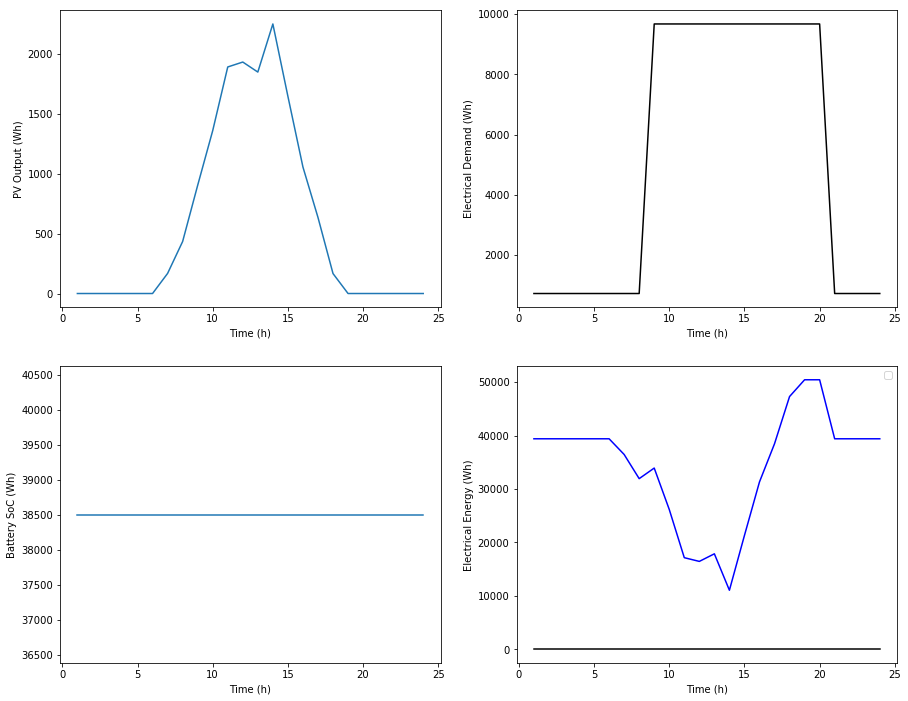

In [37]:
hours_in_day = np.arange(1, 25, 1)
day = 245

print(pve.shape)

fig, axes = plt.subplots(2, 2, figsize = (15, 12))
ax1, ax2, ax3, ax4 = axes.ravel()

#y = PV-output(Wh) x = time (hour)
ax1.plot(hours_in_day, daily_output[:, day])
ax1.set_ylabel('PV Output (Wh)')
# ax1.set_yscale('log')
ax1.set_xlabel('Time (h)')

#y = Electrical demand (Wh), x = time (hour)
#Sb = 365x25
ax2.plot(hours_in_day, demand, c = 'k')
ax2.set_ylabel('Electrical Demand (Wh)')
# ax2.set_yscale('log')
ax2.set_xlabel('Time (h)')

#y = Battery SoC (Wh), x = time (hour)
ax3.plot(hours_in_day, soc[day, :])
ax3.set_ylabel('Battery SoC (Wh)')
# ax3.set_yscale('log')
ax3.set_xlabel('Time (h)')

# y = Electrical demand (Wh), x = time (hour)
ax4.plot(hours_in_day, pve_exs[day, :], c = 'k')
ax4.plot(hours_in_day, pve_def[day, :], c = 'b')
ax4.set_ylabel('Electrical Energy (Wh)')
# ax4.set_yscale('log')
ax4.set_xlabel('Time (h)')
ax4.legend(loc = 'upper right')

plt.show()

In [38]:
soc

array([[38500., 38500., 38500., ..., 38500., 38500., 38500.],
       [38500., 38500., 38500., ..., 38500., 38500., 38500.],
       [38500., 38500., 38500., ..., 38500., 38500., 38500.],
       ...,
       [38500., 38500., 38500., ..., 38500., 38500., 38500.],
       [38500., 38500., 38500., ..., 38500., 38500., 38500.],
       [38500., 38500., 38500., ..., 38500., 38500., 38500.]])

In [39]:
pve

array([[-896.2962963, -896.2962963, -896.2962963, ..., -896.2962963,
        -896.2962963, -896.2962963],
       [-896.2962963, -896.2962963, -896.2962963, ..., -896.2962963,
        -896.2962963, -896.2962963],
       [-896.2962963, -896.2962963, -896.2962963, ..., -896.2962963,
        -896.2962963, -896.2962963],
       ...,
       [-896.2962963, -896.2962963, -896.2962963, ..., -896.2962963,
        -896.2962963, -896.2962963],
       [-896.2962963, -896.2962963, -896.2962963, ..., -896.2962963,
        -896.2962963, -896.2962963],
       [-896.2962963, -896.2962963, -896.2962963, ..., -896.2962963,
        -896.2962963, -896.2962963]])

In [6]:
pve_exs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
pve_def

array([[39395.29634824, 39396.2962963 , 37154.12266667, ...,
        37130.39166667, 37403.28166667, 39396.2962963 ],
       [39396.2962963 , 39304.24074074, 37039.69266667, ...,
        36751.70766667, 37955.03866667, 39396.2962963 ],
       [39396.2962963 , 38902.98074074, 36844.09966667, ...,
        36541.87566667, 38749.38296296, 39396.2962963 ],
       ...,
       [39396.2962963 , 38887.18740741, 37526.55666667, ...,
        36765.46666667, 38776.22074074, 39396.2962963 ],
       [39396.2962963 , 38285.77066667, 36967.31466667, ...,
        36449.23766667, 39285.26185185, 39396.2962963 ],
       [39396.2962963 , 37755.43666667, 37131.25866667, ...,
        37042.17266667, 39396.2962963 , 39396.2962963 ]])